In [ ]:
import os
import tensorflow as tf
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt
import shutil
import albumentations as alb
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D, Dropout
from tensorflow.keras.applications import VGG16
import re

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/'

In [ ]:
dic = {'blank':0, 'fist': 1, 'open':2}

In [ ]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                        bbox_params=alb.BboxParams(format='albumentations',
                                                   label_fields=['class_labels']))

In [ ]:
for partition in ['train','test','val']:
    i = 0
    for image in os.listdir(os.path.join(path,'hand_tracker', partition, 'images')):
        i += 1

        img = cv2.imread(os.path.join(path, 'hand_tracker', partition, 'images', image))

        a, b, _ = img.shape

        label_path = os.path.join(path, 'hand_tracker', partition, 'labels', image.replace('.jpg', '.json'))

        coords = [0,0, 0.0000000001, 0.000000001]

        object_name = (image.split(" ")[0]).split("_")[1]

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
              label = json.load(f)

            labels = label['shapes'][0]['points']

            coords[0] = labels[0][0]
            coords[1] = labels[0][1]
            coords[2] = labels[1][0]
            coords[3] = labels[1][1]

            temp1 = min(coords[0], coords[2])
            temp2 = max(coords[0], coords[2])
            coords[0] = temp1
            coords[2] = temp2

            temp1 = min(coords[1], coords[3])
            temp2 = max(coords[1], coords[3])
            coords[1] = temp1
            coords[3] = temp2

            coords = list(np.divide(coords, [b, a, b, a]))

        try:
            for x in range(30):
              augmented_image = augmentor(image=img, bboxes=[coords], class_labels=['blank, fist, open'])
              cv2.imwrite(os.path.join(path,'hand_aug_data', partition, 'images', f'{object_name}.{i}.{x}.jpg'), augmented_image['image'])

              annotation = {}
              annotation['image'] = image

              object_type = (image.split(" ")[0]).split("_")[1]

              if os.path.exists(label_path):
                  if len(augmented_image['bboxes']) == 0:
                      annotation['bbox'] = [0,0,0,0]
                      annotation['class'] = 0
                  else:
                       annotation['bbox'] = augmented_image['bboxes'][0]
                       annotation['class'] = object_type
              else:
                  annotation['bbox'] = [0,0,0,0]
                  annotation['class'] = 0
              with open(os.path.join(path,'hand_aug_data', partition, 'labels', f'{object_name}.{i}.{x}.json'), 'w') as f:
                  json.dump(annotation, f)
        except Exception as e:
          print (e)

In [ ]:
def image_load(x):
  byte_img = tf.io.read_file(x)
  img = tf.io.decode_jpeg(byte_img)
  return img

In [ ]:
def splitter(typ):
    image_path = os.path.join(path, 'hand_aug_data', typ, 'images')
    images = tf.data.Dataset.list_files(os.path.join(image_path, '*.jpg'), shuffle=False)

    total_files = len(os.listdir(image_path))
    num_files_to_take = total_files // 1

    images = images.take(num_files_to_take)

    images = images.map(image_load)
    images = images.map(lambda x: tf.image.resize(x, (200, 200)))
    images = images.map(lambda x: x / 255)

    return images

In [ ]:
train_images = splitter('train')

In [ ]:
test_images = splitter('test')

In [ ]:
val_images = splitter('val')

In [ ]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)

    return [label['class']], label['bbox']

In [ ]:
def label_loader(typ):
    label_path = os.path.join(path, 'aug_data', typ, 'labels')
    labels = tf.data.Dataset.list_files(os.path.join(label_path, '*.json'), shuffle=False)

    total_files = len(os.listdir(label_path))
    num_files_to_take = total_files // 1

    labels = labels.take(num_files_to_take)

    labels = labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

    return labels

In [ ]:
train_labels = label_loader('train')

In [ ]:
test_labels = label_loader('test')

In [ ]:
val_labels = label_loader('val')

In [ ]:
def dataset_creator(a, b, c):
  data = tf.data.Dataset.zip((a, b))
  data = data.shuffle(c)
  data = data.batch(32)
  data = data.prefetch(16)
  return data

In [ ]:
train = dataset_creator(train_images, train_labels, 2300)

In [ ]:
test = dataset_creator(test_images, test_labels, 600)

In [ ]:
val = dataset_creator(val_images, val_labels, 600)

In [ ]:
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
def build_model():
    input_layer = Input(shape=(200,200,3))

    vgg = VGG16(include_top=False)(input_layer)

    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(1024, activation='relu')(f1)
    class1_dropout = Dropout(0.5)(class1)
    class2 = Dense(3, activation='softmax')(class1)

    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(1024, activation='relu')(f2)
    regress1_dropout = Dropout(0.5)(regress1)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    model = Model(inputs=input_layer, outputs=[class2, regress2])
    return model

In [ ]:
model1 = build_model()

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size

In [ ]:
classloss = tf.keras.losses.CategoricalCrossentropy()
regressloss = localization_loss

In [ ]:
class Garbage_Detector(Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def compile(self, opt, classloss, localizationloss):
        super().compile()
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch):

        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss + 0.5 * batch_classloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def test_step(self, batch):
        X, y = batch

        classes, coords = self.model(X, training=False)

        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss + 0.5 * batch_classloss

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def call(self, X):
        return self.model(X)

In [ ]:
model2 = Garbage_Detector(model1)

In [ ]:
model2.compile(opt, classloss, regressloss)

In [ ]:
log_directory = '/content/drive/MyDrive/logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_directory)

In [ ]:
hist = model2.fit(train, epochs=3, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/3
60/60 [==============================] - 1144s 19s/step - total_loss: 5.0925 - class_loss: 1.0201 - regress_loss: 4.5825 - val_total_loss: 3.6023 - val_class_loss: 6.6221 - val_regress_loss: 0.2913
Epoch 2/3
60/60 [==============================] - 1114s 18s/step - total_loss: 4.7345 - class_loss: 0.9144 - regress_loss: 4.2773 - val_total_loss: 7.4769 - val_class_loss: 13.2314 - val_regress_loss: 0.8612
Epoch 3/3
60/60 [==============================] - 1123s 19s/step - total_loss: 4.1984 - class_loss: 0.9137 - regress_loss: 3.7416 - val_total_loss: 1.9030 - val_class_loss: 3.3189 - val_regress_loss: 0.2436


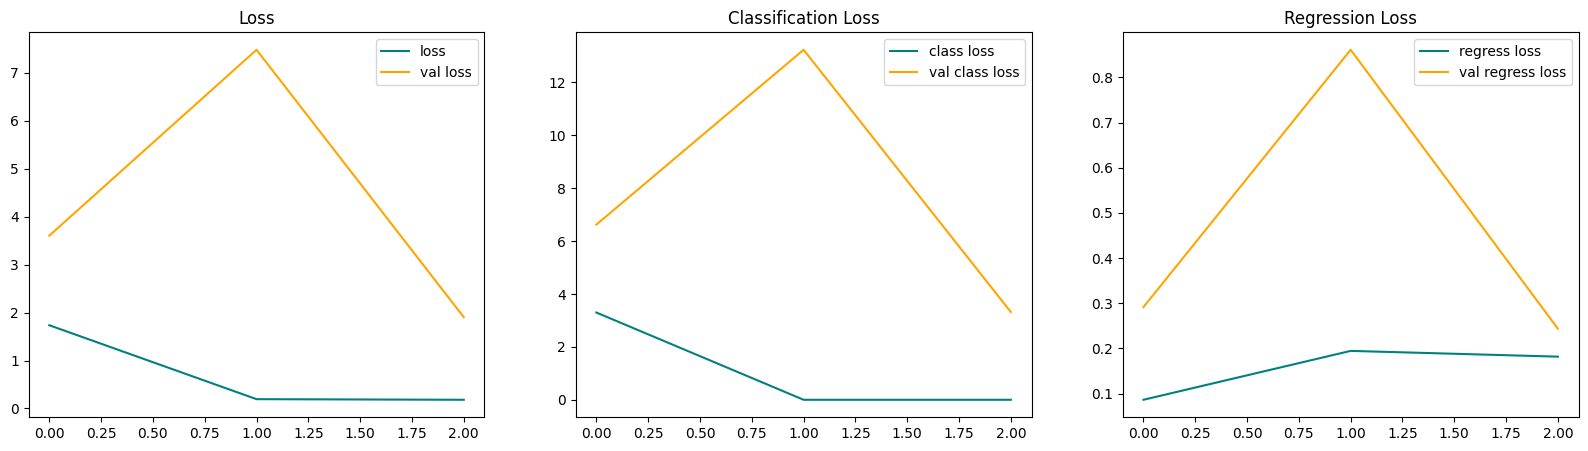

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()

StopIteration: 

In [ ]:
yhat = model1.predict(test_sample[0])

1/1 [==============================] - 2s 2s/step


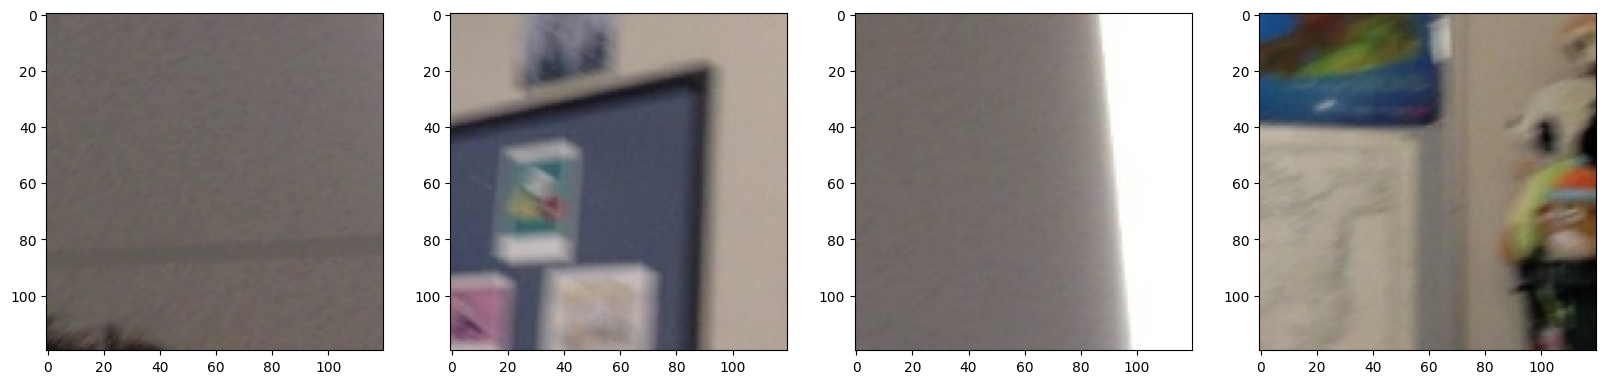

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]

    if (yhat[0][idx] > 0.4).any():
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                            (255,0,0), 2)

    ax[idx].imshow(sample_image)